# Object Detection
Object detection is an advanced computer vision task which involves both localization and classification.

## Setup TF Object Detection APIs

In [ ]:
# Get Pretrained Models and Configs
!git clone --quiet https://github.com/tensorflow/models.git

# setup protobuf
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

%cd /content/models/research/
!protoc object_detection/protos/*.proto --python_out=.

Selecting previously unselected package python-bs4.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [ ]:
# Prepare for installation
import os
import sys
os.environ['PYTHONPATH']+=":/content/models"
sys.path.append("/content/models/research")

In [ ]:
# Begin installation
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/exporter_lib_v2.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib_tf1_test.py -> build/lib/object_detection
copying object_detection/exporter_main_v2.py -> build/lib/object_detection
copying object_detection/model_lib.py -> build/lib/object_detection
copying object_detection/model_main_tf2.py -> build/lib/object_detection
copying object_detection/exporter.py -> build/lib/object_detection
copying object_detection/model_tpu_main.py -> build/lib/object_detection
copying object_detection/export_inference_graph.py -> build/lib/object_detection
copying object_detection/model_lib_v2.py -> build/lib/object_detection
copying object_detection/eval_util.py -> build/lib/object_detection
copying object_detection/eval_util_test.py -> build/lib/object_detection
copying object_detection/export_tflite_graph_lib_tf2.py -> build/lib/object_detec

## Test Setup

In [ ]:
# Maybe required if next cell fails
!pip install tf_slim

     |████████████████████████████████| 358kB 9.1MB/s 


In [ ]:
!python /content/models/research/object_detection/builders/model_builder_test.py

2020-12-06 09:00:10.413554: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


### Test Output
The output of the next cell should be similar to this:
Check installation if your output is different


``----------------------------------------------------------------------``


Ran 20 tests in 42.509s

OK (skipped=1)
Done

In [ ]:
%cd '/content/models/research/object_detection/builders/'
!python model_builder_tf2_test.py
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
print('Done')

/content/models/research/object_detection/builders
2020-12-06 09:00:13.725827: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2020-12-06 09:00:15.874102: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-06 09:00:15.928962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-06 09:00:15.929587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-12-06 09:00:15.929642: I tensorflow/stream_executo

# Object Detection using Pretrained Model

## Import Libraries

In [ ]:
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import random

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [ ]:
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
from PIL import ImageOps

**Note**

Comment out lines 32 and 33 from file ``/content/models/research/object_detection/models/ssd_efficientnet_bifpn_feature_extractor.py `` before executing the following cell

This is safe to do as we are not using EfficientDet in this notebook

In [ ]:
# Import Object Detection APIs
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

In [ ]:
%matplotlib inline

## Utilities

In [ ]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [ ]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.6)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
    plt.show()

In [ ]:
def download_and_resize_image(url, new_width=512, new_height=512,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## MS-COCO Labels and Category Index

In [ ]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Load and Annotate Custom Dataset

+ We will create a dataset to identify people with masks
+ Dataset is available here : [roboflow.ai](https://public.roboflow.com/object-detection/mask-wearing/1/download/tensorflow)
+ Sign-in and select Tensorflow Dataset as download option
+ Copy the link and paste below

In [ ]:
%cd /content
!curl -L "https://public.roboflow.com/ds/tnqqjkjRjH?key=MfBzjO8uxN" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   893  100   893    0     0   1193      0 --:--:-- --:--:-- --:--:--  1193
100 3775k  100 3775k    0     0  4042k      0 --:--:-- --:--:-- --:--:--  355M
Archive:  roboflow.zip
 extracting: test/w1240-p16x9-fa978043deff83fed485af12d16e39c61398fc30_jpg.rf.185d01b7e55e049c6661b8ecd49679fc.jpg  
 extracting: test/15391513324714o1n0r10n6_jpg.rf.a91fbc7be8a94ed3c48d2e4b35bd53bb.jpg  
 extracting: test/1224331650_g_400-w_g_jpg.rf.b816f49e2d84044fc997a8cbd55c347d.jpg  
 extracting: test/15391513329330sooq10859_jpg.rf.89c8524c2096175fa2c728e5d73f1c28.jpg  
 extracting: test/126202-untitled-design-13_jpg.rf.56b50d413464989bb2232448a8fbb915.jpg  
 extracting: test/w1240-p16x9-2019-10-04t075956z_1862636027_rc15d4d49d00_rtrmadp_3_hongkong-protests_jpg.rf.061f2c7f7d17a0b472510eadb717a0b9.jpg  
 extracting: test/the-first-day-of-wu

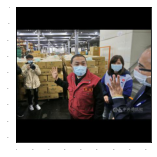

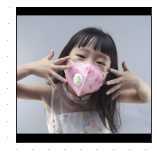

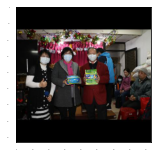

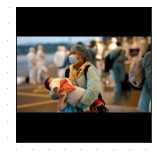

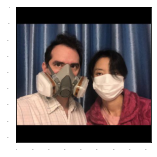

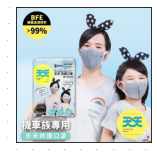

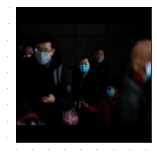

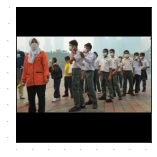

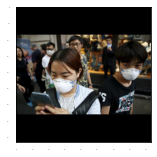

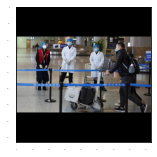

In [ ]:
# Load images and visualize
train_image_dir = '/content/train/'
train_images_np = []
train_files = os.listdir(train_image_dir)
for f in train_files[:10]:
  image_path = os.path.join(train_image_dir, f)
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 5, idx+1)
  plt.imshow(train_image_np)
  plt.show()

In [ ]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Hand Annotated samples
gt_boxes

[array([[0.42      , 0.40384615, 0.50166667, 0.52163462],
        [0.41833333, 0.69230769, 0.47833333, 0.79807692],
        [0.45833333, 0.86298077, 0.58666667, 0.99278846],
        [0.39666667, 0.07932692, 0.425     , 0.13221154]]),
 array([[0.35833333, 0.34615385, 0.67      , 0.67307692]]),
 array([[0.35666667, 0.15865385, 0.42666667, 0.26201923],
        [0.34      , 0.34134615, 0.40166667, 0.42788462],
        [0.34833333, 0.52884615, 0.39833333, 0.60817308]]),
 array([[0.35      , 0.38461538, 0.43      , 0.48076923]]),
 array([[0.41666667, 0.21153846, 0.68166667, 0.50480769],
        [0.50333333, 0.5625    , 0.69833333, 0.8125    ]]),
 array([[0.28833333, 0.45192308, 0.465     , 0.67067308],
        [0.52833333, 0.75240385, 0.68666667, 0.97355769],
        [0.59166667, 0.24278846, 0.63833333, 0.31971154],
        [0.65666667, 0.33413462, 0.70166667, 0.40625   ]]),
 array([[0.415     , 0.45673077, 0.48      , 0.55769231],
        [0.31666667, 0.12980769, 0.43833333, 0.28365385],
  

In [ ]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
mask_class_id = 1
num_classes = 1

category_index = {mask_class_id: {'id': mask_class_id, 'name': 'face_mask'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


## Inference on Custom Dataset 

### Load Model

In [ ]:
%cd '/content/models/research/object_detection/builders/'

/content/models/research/object_detection/builders


In [ ]:
Downloading data from http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
----------------------------

In [ ]:
#model_name = 'ssd_mobilenet_v2_coco_2017_11_17'
model_name = 'ssd_mobilenet_v2_coco_2018_03_29'
detection_model = load_model(model_name)

187932672/187925923 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [ ]:
detection_model.signatures['serving_default'].output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [ ]:
detection_model.signatures['serving_default'].output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

### Visualize Results

In [ ]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/test/')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS[:10]

[PosixPath('/content/test/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.3135dfc5feab288d76a4ccfd22dfc5bf.jpg'),
 PosixPath('/content/test/1224331650_g_400-w_g_jpg.rf.b816f49e2d84044fc997a8cbd55c347d.jpg'),
 PosixPath('/content/test/126202-untitled-design-13_jpg.rf.56b50d413464989bb2232448a8fbb915.jpg'),
 PosixPath('/content/test/1288126-10255706714jpg_jpg.rf.95f7324cbfd48e0386e0660b5e932223.jpg'),
 PosixPath('/content/test/15391513324714o1n0r10n6_jpg.rf.a91fbc7be8a94ed3c48d2e4b35bd53bb.jpg'),
 PosixPath('/content/test/15391513329330sooq10859_jpg.rf.89c8524c2096175fa2c728e5d73f1c28.jpg'),
 PosixPath('/content/test/1579924271_jpg.rf.be5b27c2b2801bccc191e6dbd9bfccca.jpg'),
 PosixPath('/content/test/RTX7CCFN_jpg.rf.66ed5c5054f30d933d19ab3d56ace004.jpg'),
 PosixPath('/content/test/phplpE73q_jpg.rf.bd81cab9f8ff2674ce2e58278f7d37fa.jpg'),
 PosixPath('/content/test/r1p00017o8171pnq407_jpg.rf.6fd25b7219a249e97f54fcabf2b52726.jpg')]

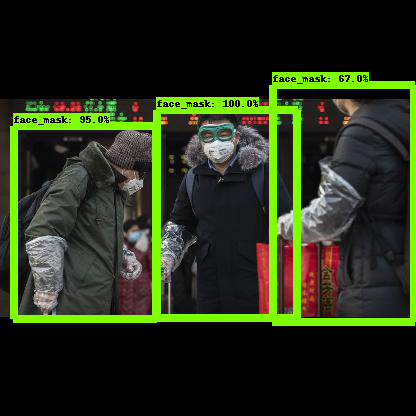

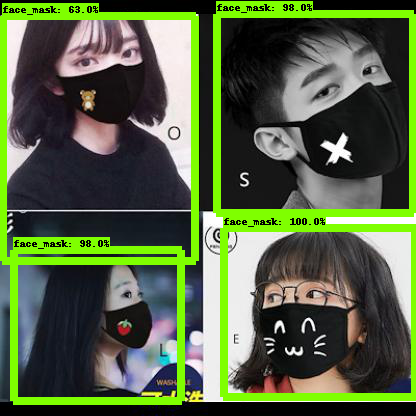

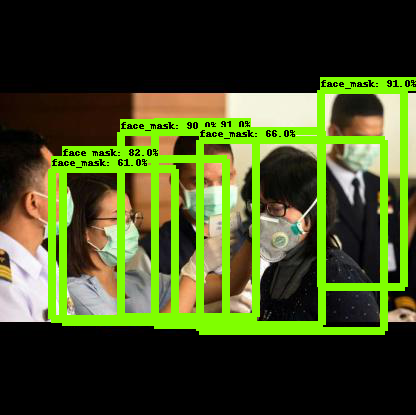

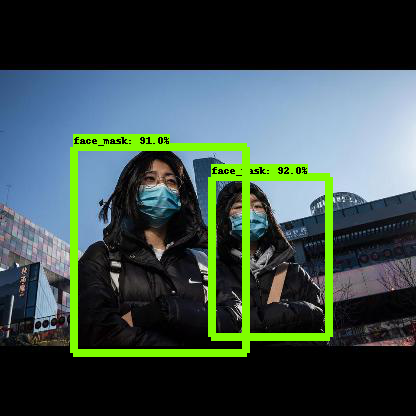

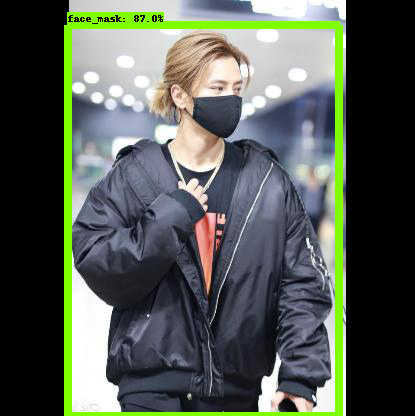

In [ ]:
for image_path in TEST_IMAGE_PATHS[:5]:
  show_inference(detection_model, image_path)

# Finetune Pretrained Model

## Get Model Weights/Checkpoint

In [ ]:
%cd '/content/models/research/object_detection/'

/content/models/research/object_detection


In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/
# check for-> ssd_mobilenet_v1_coco_2017_11_17
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
#!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-12-06 09:32:01--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   244MB/s    in 1.0s    

2020-12-06 09:32:02 (244 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint /content/models/research/object_detection/test_data/

## Setup Model and Weights

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = '/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = '/content/models/research/object_detection/test_data/checkpoint/ckpt-0'

Building model and restoring weights for fine-tuning...


In [ ]:
# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new face_mask class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

In [ ]:
# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

In [ ]:
# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


## Setup Parameters for Training

In [ ]:
batch_size = 4
learning_rate = 0.01
num_batches = 150

### Mark Frozen and Trainable Layers

In [ ]:
# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

## Custom Training Loop

In [ ]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function(experimental_relax_shapes=True)
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

## Compile Model

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

## Train

In [ ]:
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 150, loss=1.5257338
batch 10 of 150, loss=0.7885269
batch 20 of 150, loss=0.4504875
batch 30 of 150, loss=0.42815536
batch 40 of 150, loss=0.281438
batch 50 of 150, loss=0.27481675
batch 60 of 150, loss=0.2223042
batch 70 of 150, loss=0.19404395
batch 80 of 150, loss=0.21533369
batch 90 of 150, loss=0.18043806
batch 100 of 150, loss=0.15369359
batch 110 of 150, loss=0.14402075
batch 120 of 150, loss=0.123911396
batch 130 of 150, loss=0.0991138
batch 140 of 150, loss=0.08755363
Done fine-tuning!


## Inference using Fine-tuned Model on Custom Dataset

In [ ]:
test_images_np = []
test_image_dir = '/content/test/'
for f in TEST_IMAGE_PATHS:
  image_path = os.path.join(test_image_dir, f)
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

### Prediction Utility

In [ ]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

In [ ]:
label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="/content/output/gif_frame_" + ('%02d' % i) + ".jpg")

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)3194880/4830080 bytes (66.1%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


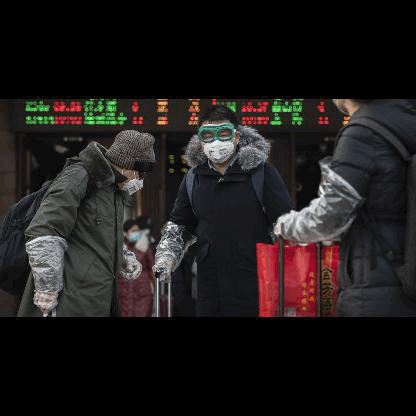

In [ ]:
import imageio
import glob
from IPython.display import Image as IPyImage

imageio.plugins.freeimage.download()

anim_file = '/content/mask_test.gif'

filenames = glob.glob('/content/output/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=0.5)

display(IPyImage(open(anim_file, 'rb').read()))

In [ ]:
!zip /content/output.zip /content/output/* 

  adding: content/output/gif_frame_00.jpg (deflated 7%)
  adding: content/output/gif_frame_01.jpg (deflated 3%)
  adding: content/output/gif_frame_02.jpg (deflated 6%)
  adding: content/output/gif_frame_03.jpg (deflated 6%)
  adding: content/output/gif_frame_04.jpg (deflated 4%)
  adding: content/output/gif_frame_05.jpg (deflated 4%)
  adding: content/output/gif_frame_06.jpg (deflated 4%)
  adding: content/output/gif_frame_07.jpg (deflated 6%)
  adding: content/output/gif_frame_08.jpg (deflated 3%)
  adding: content/output/gif_frame_09.jpg (deflated 3%)
  adding: content/output/gif_frame_10.jpg (deflated 5%)
  adding: content/output/gif_frame_11.jpg (deflated 6%)
  adding: content/output/gif_frame_12.jpg (deflated 8%)
  adding: content/output/gif_frame_13.jpg (deflated 5%)
  adding: content/output/gif_frame_14.jpg (deflated 8%)
